In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve, hhRNADataset, hhATACDataset, test_paul, symsim_batches, cardiacRNADataset, cardiacATACDataset

from utils import *

In [2]:
def traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1):
    loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    
    latent_sim = pairwise_distance(z)
#     print(np.isnan(latent_sim.detach().numpy()))
    
#     assert False
#     diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
    
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
    diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [3]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1)
    
    DPT1 = torch.FloatTensor(DPT1)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2)
    
    DPT2 = torch.FloatTensor(DPT2)

In [58]:
class Discriminator(nn.Module):
    def __init__(self, in_features, layers, n_class):
        super(Discriminator, self).__init__()
        
        modules = []
        last_layer_size = in_features
        for l in layers:
            modules.append(nn.Linear(last_layer_size, l))
            modules.append(nn.ReLU())
            last_layer_size = l
        
        modules.append(nn.Linear(last_layer_size, n_class))
        modules.append(nn.LogSoftmax(dim=1))
        self.main = nn.Sequential(*modules)

In [55]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, diff_sim_atac, n_epochs = 50, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1):

    optimizer_rna = torch.optim.Adam(model_rna.parameters(), lr = learning_rate)
    optimizer_atac = torch.optim.Adam(model_atac.parameters(), lr = learning_rate)
    optimizer_D = torch.optim.Adam(disc.parameters(), lr = learning_rate)

    for epoch in range(n_epochs):
        iteration = max(len(data_loader_rna), len(data_loader_atac))
        for data in zip(data_loader_rna, data_loader_atac):
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index']
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count']

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)

            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(batch_expr_r_rna, batch_expr_rna, z_rna, batch_sim_rna, lamb_r, lamb_d)

            # train_loss_rna.backward(retain_graph=True)
            # optimizer_rna.step()
            # optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index']
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count']

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(batch_expr_r_atac, batch_expr_atac, z_atac, batch_sim_atac, lamb_r, lamb_d)

            # train_loss_atac.backward(retain_graph=True)
            # optimizer_atac.step()
            # optimizer_atac.zero_grad()

            # Update Discriminator
            D_loss_avg = 0
            n_iter = 6
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            for i in range(n_iter):
                target = torch.cat((torch.full((n_rna, ), 0), torch.full((n_atac, ), 1)))
                output = torch.cat((disc(z_rna), disc(z_atac)))
                D_loss = F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward(retain_graph=True)
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -4 * D_loss
            E_loss.backward(retain_graph=True)
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)

In [56]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder1", ae.Encoder(symsim_CONFIG)), 
        ("decoder1", ae.Decoder(symsim_CONFIG))
      ]))

ae2 = nn.Sequential(OrderedDict([
        ("encoder2", ae.Encoder(symsim_CONFIG)), 
        ("decoder2", ae.Decoder(symsim_CONFIG))
      ]))

In [57]:
train_unpaired(ae1, ae2, ae.discriminator(), train_r1b1_loader, train_r1b2_loader, DPT1, DPT2, n_epochs=61, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1)

epoch:  0 RNA loss: 10.42240, RNA recon loss: 11.36106, RNA dist loss: -0.93866 ATAC loss: 9.69552, ATAC recon loss: 10.53365, ATAC dist loss: -0.83813 Discriminator loss: 0.62005
epoch:  10 RNA loss: 10.48982, RNA recon loss: 11.42509, RNA dist loss: -0.93527 ATAC loss: 9.77205, ATAC recon loss: 10.47121, ATAC dist loss: -0.69917 Discriminator loss: 0.05673
epoch:  20 RNA loss: 10.36666, RNA recon loss: 11.31943, RNA dist loss: -0.95277 ATAC loss: 9.78388, ATAC recon loss: 10.49323, ATAC dist loss: -0.70935 Discriminator loss: 0.00660


KeyboardInterrupt: 

## Merged Branch

(1009, 2)
(2000, 2)


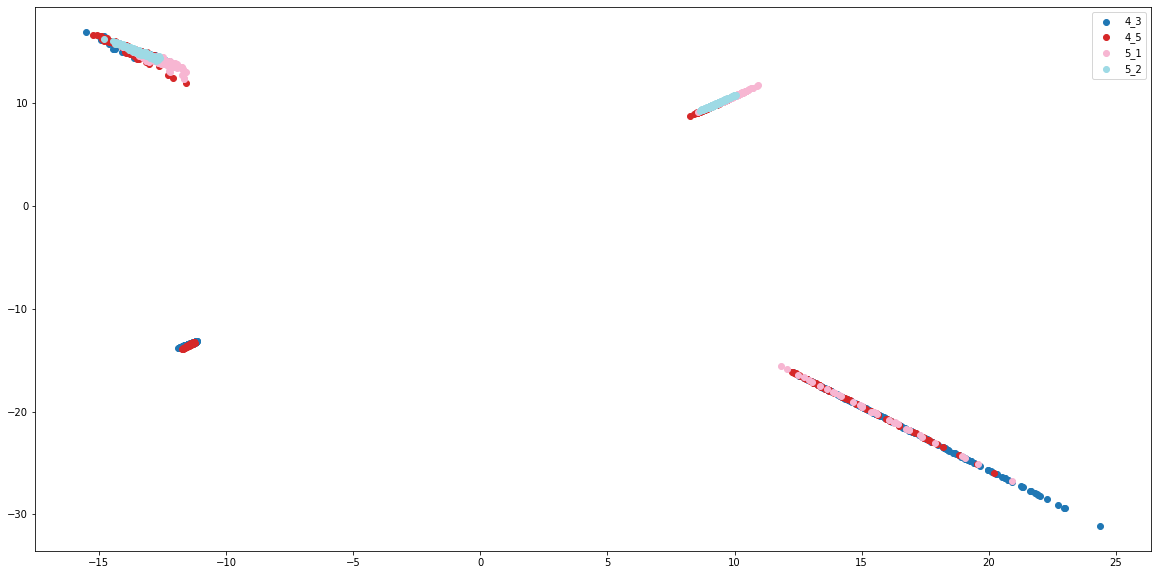

In [42]:
ae1.eval()
ae2.eval()
for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count']).detach().numpy()
for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count']).detach().numpy()
ae_coordinates = np.concatenate((ae_coordinates1, ae_coordinates2))
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

print(ae_coordinates1.shape)
print(ae_coordinates.shape)

# data 3, oeHBC data, small one 
cell_type = np.concatenate((symsim_r1b1.cell_labels["pop"].values, symsim_r1b2.cell_labels["pop"].values))
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

## Merged Batch

(1009, 2)
(2000, 2)


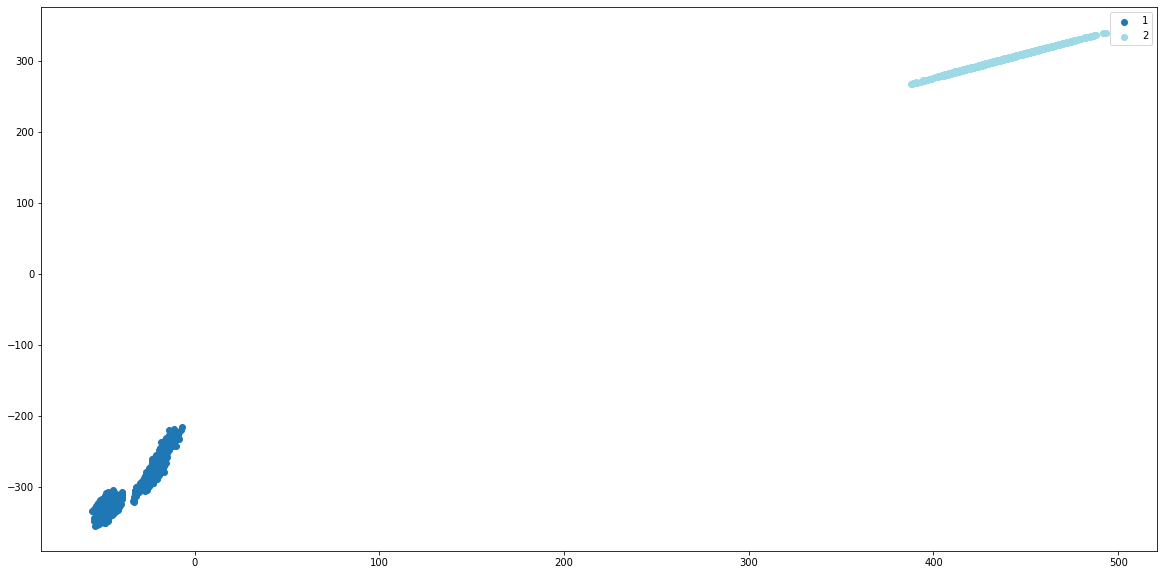

In [46]:
ae1.eval()
ae2.eval()
for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count']).detach().numpy()
for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count']).detach().numpy()
ae_coordinates = np.concatenate((ae_coordinates1, ae_coordinates2))
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

print(ae_coordinates1.shape)
print(ae_coordinates.shape)

# data 3, oeHBC data, small one 
cell_type = np.concatenate((np.full((ae_coordinates1.shape[0], ), 1), np.full((ae_coordinates2.shape[0], ), 2)))
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

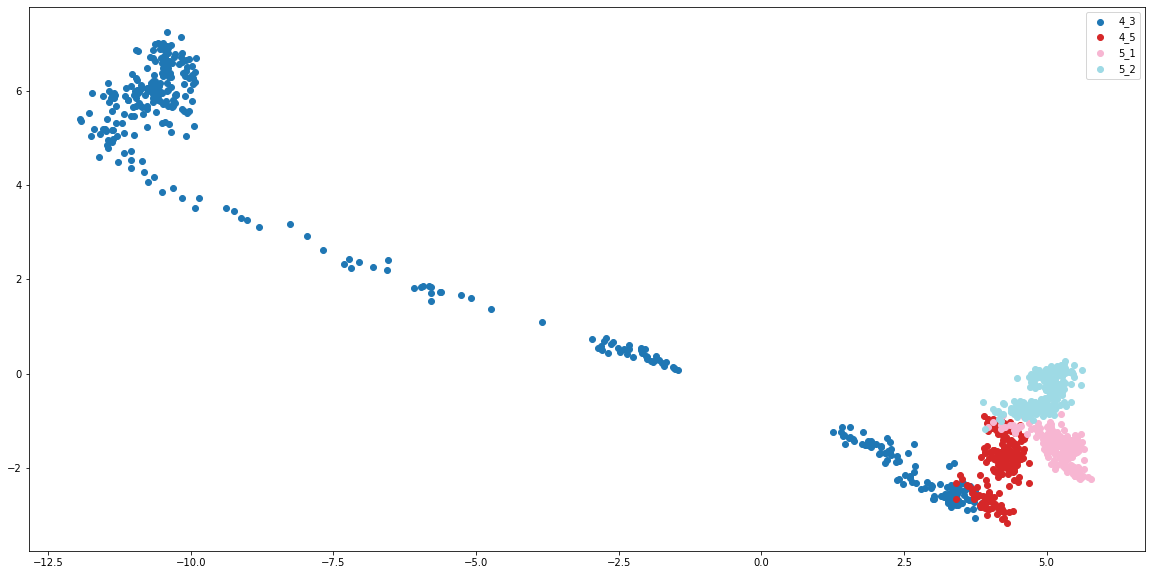

In [10]:
ae1.eval()
for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

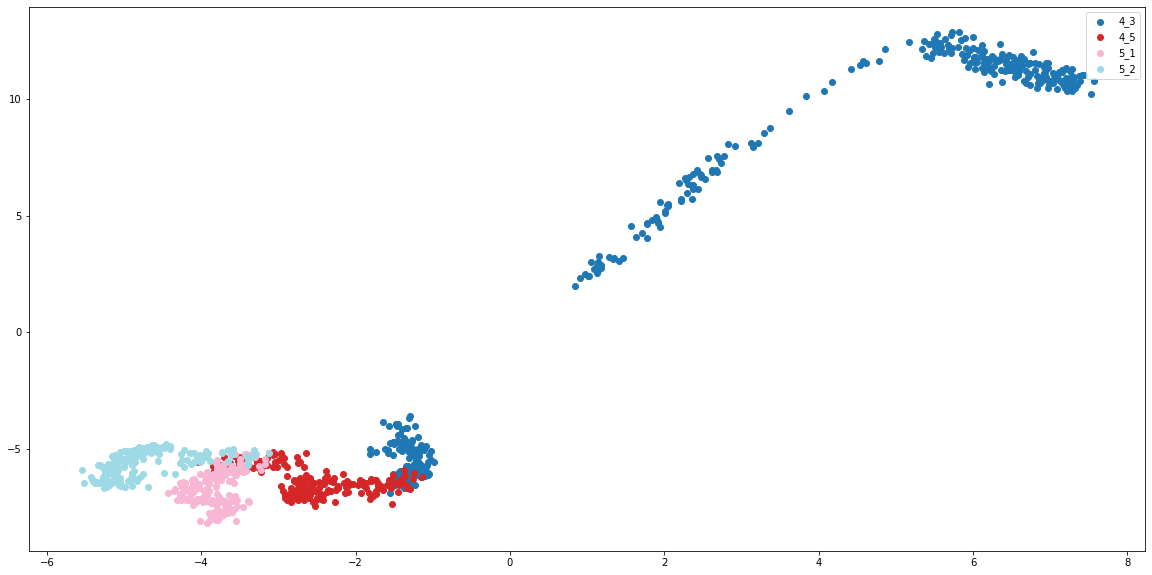

In [11]:
ae2.eval()
for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)